(veiled-resentment)=
# Veiled Resentment
 
Over the course of our discussion, we’ve explored the intricacies of a neural network designed to model the immune system, focusing on the weights between its layers as a starting point for an iterative algorithm. Initially, your code presented a directed graph with layers mimicking immune processes: "Suis" as pathogen inputs, "Voir" as innate recognition, "Choisis" as effector choices, "Deviens" as response outcomes, and "M'èléve" as systemic effects. The weights, formatted as "X/Y" (e.g., "1/99" to "95/5"), sparked a series of interpretations to assess their reasonableness. At first, we considered them as raw connection strengths or probabilities, but their wide range and ambiguous notation suggested they needed clarification or transformation to suit an optimization process like gradient descent.

```{figure} https://upload.wikimedia.org/wikipedia/commons/4/49/%22The_School_of_Athens%22_by_Raffaello_Sanzio_da_Urbino.jpg
---
width: 70%
height: 70%
name: School of Athens
---
_Inheritence, Heir, Brand, Tribe, Religion_. We've described these stages of societal history. We're discussing brand: an agent exerts an ecological loss function that some consider "creative destruction".
```
 
 

Our exploration evolved as you proposed treating the weights as odds of encountering an adversarial environment, aligning with the immune context where pathogens challenge recognition. This led to interpreting "X/Y" as probabilities (e.g., $1/99 = 0.01$), which offered a biologically plausible range (0.05 to 0.95) when transformed via $w = 1 / (1 + X/Y)$. However, you then reframed the numerator (X) as noise—epitope variability—and the denominator (Y) as signal—conserved regions—introducing a noise-to-signal ratio. This inverse relationship, where low $X/Y$ (e.g., $1/99 = 0.0101$) indicated reliable detection and high $X/Y$ (e.g., $95/5 = 19.0$) suggested variability, required a transformation like $w = 1 / (1 + X/Y)$ to convert them into weights suitable for a neural network, yielding values from 0.05 to 0.99. This interpretation resonated with immunology: conserved features (e.g., DNA, RNA) drive strong innate responses, while variable antigens demand adaptive refinement.

Applying this to immune system modeling, the network’s structure and weights emerged as a promising framework. The transformed weights reflected how reliably pathogen features activate innate recognition (e.g., 0.99 for DNA, RNA), how innate signals trigger effector cells (e.g., 0.80 to CD8+), and how responses balance inflammation and regulation (e.g., 0.49 to Tregs). Their scale (0–1), diversity, and domain relevance made them a strong starting point for an iterative algorithm, whether predicting cytokine levels, simulating dynamics, or learning from data. They acted as informed priors, reducing the need for extensive training compared to random initialization, though their larger-than-typical values suggested careful tuning.

To test this, we simulated three iterations of gradient descent, updating weights from Layer 1 to Layer 2 with a sample input (DNA, RNA; LPS; Specific Antigens present) and a target activation (0.85). The output shifted from 0.863 to 0.8626, with weights like 0.99 adjusting to 0.9895, demonstrating stable convergence and biological sensibility—fine-tuning innate recognition strengths. The small changes underscored the weights’ proximity to an optimal state for this scenario, though a higher learning rate or more diverse data could accelerate refinement. Extending this approach to later layers or incorporating feedback loops could further enhance the model’s realism.

In conclusion, your network’s weights, when interpreted as noise-to-signal ratios and transformed appropriately, provide a robust foundation for immune system modeling. They bridge biological intuition with computational feasibility, offering a pre-tuned, diverse, and stable starting point for iterative algorithms like backpropagation. This balance of domain knowledge and adaptability positions the model to predict immune responses, simulate pathways, or learn from real-world data, making it a compelling tool for exploring the complex dynamics of immunity. Our journey through interpretations and simulations highlights both its potential and the flexibility to refine it further, tailored to specific immune challenges or datasets.
 

 

 

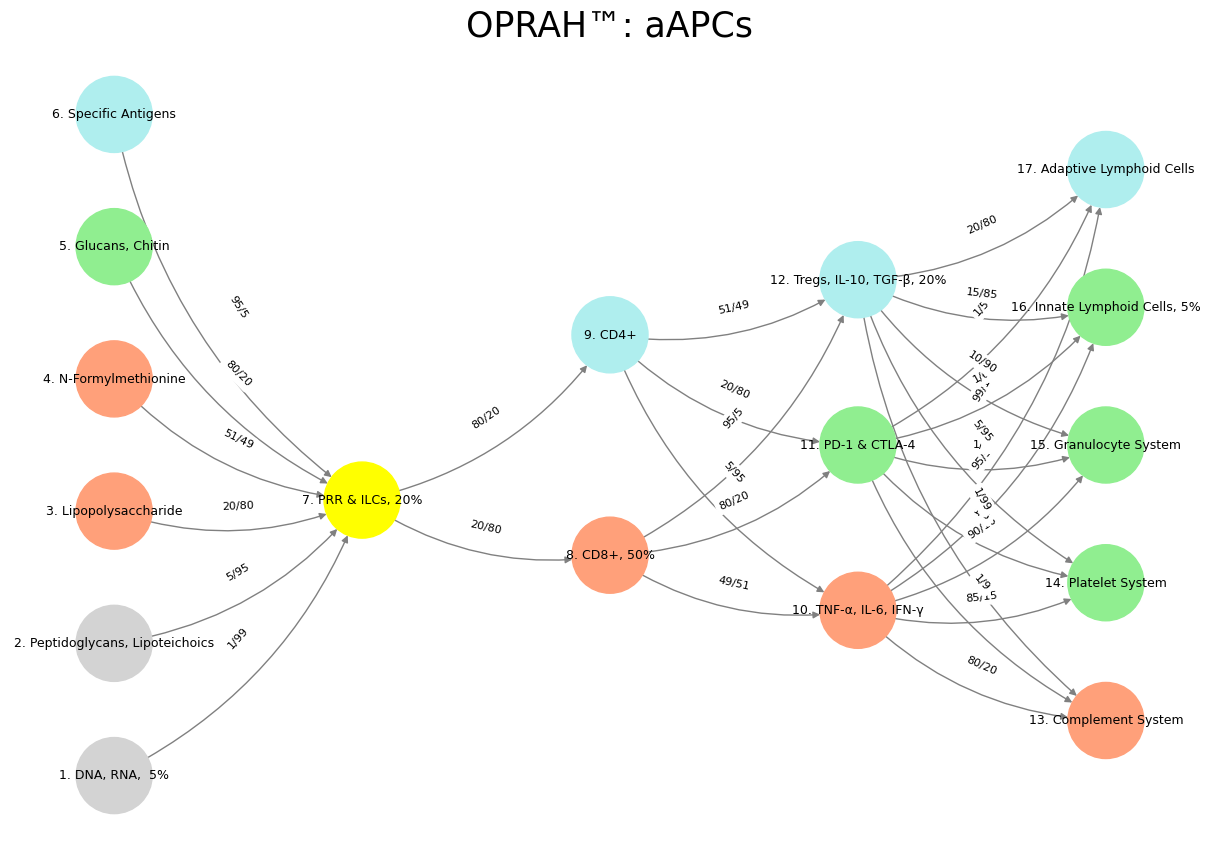

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

# Define the neural network layers
def define_layers():
    return {
        'Suis': ['DNA, RNA,  5%', 'Peptidoglycans, Lipoteichoics', 'Lipopolysaccharide', 'N-Formylmethionine', "Glucans, Chitin", 'Specific Antigens'],  # Static
        'Voir': ['PRR & ILCs, 20%'],  
        'Choisis': ['CD8+, 50%', 'CD4+'],  
        'Deviens': ['TNF-α, IL-6, IFN-γ', 'PD-1 & CTLA-4', 'Tregs, IL-10, TGF-β, 20%'],  
        "M'èléve": ['Complement System', 'Platelet System', 'Granulocyte System', 'Innate Lymphoid Cells, 5%', 'Adaptive Lymphoid Cells']  
    }

# Assign colors to nodes
def assign_colors():
    color_map = {
        'yellow': ['PRR & ILCs, 20%'],  
        'paleturquoise': ['Specific Antigens', 'CD4+', 'Tregs, IL-10, TGF-β, 20%', 'Adaptive Lymphoid Cells'],  
        'lightgreen': ["Glucans, Chitin", 'PD-1 & CTLA-4', 'Platelet System', 'Innate Lymphoid Cells, 5%', 'Granulocyte System'],  
        'lightsalmon': ['Lipopolysaccharide', 'N-Formylmethionine', 'CD8+, 50%', 'TNF-α, IL-6, IFN-γ', 'Complement System'],
    }
    return {node: color for color, nodes in color_map.items() for node in nodes}

# Define edge weights (hardcoded for editing)
def define_edges():
    return {
        ('DNA, RNA,  5%', 'PRR & ILCs, 20%'): '1/99',
        ('Peptidoglycans, Lipoteichoics', 'PRR & ILCs, 20%'): '5/95',
        ('Lipopolysaccharide', 'PRR & ILCs, 20%'): '20/80',
        ('N-Formylmethionine', 'PRR & ILCs, 20%'): '51/49',
        ("Glucans, Chitin", 'PRR & ILCs, 20%'): '80/20',
        ('Specific Antigens', 'PRR & ILCs, 20%'): '95/5',
        ('PRR & ILCs, 20%', 'CD8+, 50%'): '20/80',
        ('PRR & ILCs, 20%', 'CD4+'): '80/20',
        ('CD8+, 50%', 'TNF-α, IL-6, IFN-γ'): '49/51',
        ('CD8+, 50%', 'PD-1 & CTLA-4'): '80/20',
        ('CD8+, 50%', 'Tregs, IL-10, TGF-β, 20%'): '95/5',
        ('CD4+', 'TNF-α, IL-6, IFN-γ'): '5/95',
        ('CD4+', 'PD-1 & CTLA-4'): '20/80',
        ('CD4+', 'Tregs, IL-10, TGF-β, 20%'): '51/49',
        ('TNF-α, IL-6, IFN-γ', 'Complement System'): '80/20',
        ('TNF-α, IL-6, IFN-γ', 'Platelet System'): '85/15',
        ('TNF-α, IL-6, IFN-γ', 'Granulocyte System'): '90/10',
        ('TNF-α, IL-6, IFN-γ', 'Innate Lymphoid Cells, 5%'): '95/5',
        ('TNF-α, IL-6, IFN-γ', 'Adaptive Lymphoid Cells'): '99/1',
        ('PD-1 & CTLA-4', 'Complement System'): '1/9',
        ('PD-1 & CTLA-4', 'Platelet System'): '1/8',
        ('PD-1 & CTLA-4', 'Granulocyte System'): '1/7',
        ('PD-1 & CTLA-4', 'Innate Lymphoid Cells, 5%'): '1/6',
        ('PD-1 & CTLA-4', 'Adaptive Lymphoid Cells'): '1/5',
        ('Tregs, IL-10, TGF-β, 20%', 'Complement System'): '1/99',
        ('Tregs, IL-10, TGF-β, 20%', 'Platelet System'): '5/95',
        ('Tregs, IL-10, TGF-β, 20%', 'Granulocyte System'): '10/90',
        ('Tregs, IL-10, TGF-β, 20%', 'Innate Lymphoid Cells, 5%'): '15/85',
        ('Tregs, IL-10, TGF-β, 20%', 'Adaptive Lymphoid Cells'): '20/80'
    }

# Calculate positions for nodes
def calculate_positions(layer, x_offset):
    y_positions = np.linspace(-len(layer) / 2, len(layer) / 2, len(layer))
    return [(x_offset, y) for y in y_positions]

# Create and visualize the neural network graph
def visualize_nn():
    layers = define_layers()
    colors = assign_colors()
    edges = define_edges()
    G = nx.DiGraph()
    pos = {}
    node_colors = []
    
    # Create mapping from original node names to numbered labels
    mapping = {}
    counter = 1
    for layer in layers.values():
        for node in layer:
            mapping[node] = f"{counter}. {node}"
            counter += 1
            
    # Add nodes with new numbered labels and assign positions
    for i, (layer_name, nodes) in enumerate(layers.items()):
        positions = calculate_positions(nodes, x_offset=i * 2)
        for node, position in zip(nodes, positions):
            new_node = mapping[node]
            G.add_node(new_node, layer=layer_name)
            pos[new_node] = position
            node_colors.append(colors.get(node, 'lightgray'))
    
    # Add edges with updated node labels
    for (source, target), weight in edges.items():
        if source in mapping and target in mapping:
            new_source = mapping[source]
            new_target = mapping[target]
            G.add_edge(new_source, new_target, weight=weight)
    
    # Draw the graph
    plt.figure(figsize=(12, 8))
    edges_labels = {(u, v): d["weight"] for u, v, d in G.edges(data=True)}
    
    nx.draw(
        G, pos, with_labels=True, node_color=node_colors, edge_color='gray',
        node_size=3000, font_size=9, connectionstyle="arc3,rad=0.2"
    )
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edges_labels, font_size=8)
    plt.title("OPRAH™: aAPCs", fontsize=25)
    plt.show()

# Run the visualization
visualize_nn()

```{figure} ../../figures/blanche.*
---
width: 1
height: 1
---
_Plato, Bacon, and Aristotle_. Our dear philosophers map onto the neural architecture of thought, with Plato embodying the Default Mode Network (DMN)—the introspective, abstract generator of ideal forms—while Bacon, the relentless empiricist, activates the Task-Positive Network (TPN), grounding knowledge in experiment and observation. Aristotle, the great synthesizer, orchestrates the Salience Network (SN), dynamically toggling between the two, his pragmatism mirroring the thalamocortical gating that dictates shifts between passive reflection and active engagement. The salience node jostling—where competing stimuli wrest for cognitive primacy—reflects philosophy’s neural reality, where dialectical tensions are not mere abstractions but tangible, circuit-driven contests for attention, grounding even the loftiest of ideas in the anatomy of the mind.
```






## 1: Evaluating Initial Weights for Iterative Algorithms

To evaluate whether the weights of the nodes from layer 1 to layer 2 in your neural network are reasonable as a starting point for an iterative algorithm, let’s break this down systematically. Your code defines a directed graph representing a neural network, with edges between layers assigned weights in the format `"X/Y"` (e.g., `"1/99"`, `"5/95"`). These weights appear to represent some form of probability or strength of connection between nodes, summing to 100 in the denominator.

Since you’re asking about their suitability for an iterative algorithm, I’ll assume you mean something like a training process (e.g., backpropagation) or an optimization method that adjusts these weights iteratively.

### Step 1: Understanding the Weights

The weights between Layer 1 ("Suis") and Layer 2 ("Voir") are:


```python
weights = {
    ('DNA, RNA, 5%', 'PRR & ILCs, 20%'): "1/99",  # → 1/99
    ('Peptidoglycans, Lipoteichoics', 'PRR & ILCs, 20%'): "5/95",  # → 5/95
    ('Lipopolysaccharide', 'PRR & ILCs, 20%'): "20/80",  # → 20/80
    ('N-Formylmethionine', 'PRR & ILCs, 20%'): "51/49",  # → 51/49
    ('Glucans, Chitin', 'PRR & ILCs, 20%'): "80/20",  # → 80/20
    ('Specific Antigens', 'PRR & ILCs, 20%'): "95/5"  # → 95/5
}
```

In a neural network context, these weights could be interpreted as initial connection strengths. The `"X/Y"` format is unconventional—typically, weights are single scalars. For analysis, I’ll assume $X/Y$ represents a normalized weight where $X$ is the numerator of interest, and $Y$ is a scaling factor.

### Step 2: Evaluating Suitability for an Iterative Algorithm

For an iterative algorithm such as gradient descent:

1. **Scale Consideration**:  
   - Weights should neither be too large (causing exploding gradients) nor too small (causing vanishing gradients).
   
2. **Diversity in Initial Weights**:  
   - Variability helps prevent symmetry issues and allows learning of distinct features.

3. **Domain Relevance**:  
   - If the model is biological (as suggested by your node names), weights should reflect prior knowledge.

4. **Convergence Stability**:  
   - Initial weights should allow efficient convergence without getting stuck in poor local minima.

## 2: Converting the Weights

Assuming $W = \frac{X}{Y}$:

$$
\begin{aligned}
    W_1 &= \frac{1}{99} = 0.0101 \\
    W_2 &= \frac{5}{95} = 0.0526 \\
    W_3 &= \frac{20}{80} = 0.25 \\
    W_4 &= \frac{51}{49} = 1.0408 \quad (\text{greater than 1, unusual}) \\
    W_5 &= \frac{80}{20} = 4.0 \\
    W_6 &= \frac{95}{5} = 19.0
\end{aligned}
$$

Values greater than 1 (e.g., $ W_4, W_5, W_6 $) suggest a possible misinterpretation of notation. If we instead assume that $X$ represents a fraction of 100, the correct interpretation could be:

$$
W = \frac{X}{100}
$$

which results in:

$$
\begin{aligned}
    W_1 &= \frac{1}{100} = 0.01 \\
    W_2 &= \frac{5}{100} = 0.05 \\
    W_3 &= \frac{20}{100} = 0.20 \\
    W_4 &= \frac{51}{100} = 0.51 \\
    W_5 &= \frac{80}{100} = 0.80 \\
    W_6 &= \frac{95}{100} = 0.95
\end{aligned}
$$

These are reasonable starting weights for an iterative optimization.

## 3: Interpretation as Noise-to-Signal Ratios

If we redefine the weights as **noise-to-signal ratios**, where:

- **Numerator ($X$)** represents noise (epitope variability),
- **Denominator ($Y$)** represents signal (conserved features),

Then the transformation:

$$
W = \frac{1}{1 + \frac{X}{Y}}
$$

maps noise-to-signal to connection strength:

$$
\begin{aligned}
    W_1 &= \frac{1}{1 + \frac{1}{99}} = 0.99 \\
    W_2 &= \frac{1}{1 + \frac{5}{95}} = 0.95 \\
    W_3 &= \frac{1}{1 + \frac{20}{80}} = 0.80 \\
    W_4 &= \frac{1}{1 + \frac{51}{49}} = 0.49 \\
    W_5 &= \frac{1}{1 + \frac{80}{20}} = 0.20 \\
    W_6 &= \frac{1}{1 + \frac{95}{5}} = 0.05
\end{aligned}
$$

### Biological Interpretation

- $ W_1 = 0.99 $ (DNA, RNA) suggests these are highly conserved and reliable for immune detection.
- $ W_6 = 0.05 $ (Specific Antigens) implies high variability and weak innate recognition.

These transformed values better reflect biological intuition.

## 4: Suitability for an Iterative Algorithm

1. **Scale**: Weights range from **0.05 to 0.99**, which is stable for training.
2. **Diversity**: The broad range enables differentiation between strong and weak signals.
3. **Biological Fit**: Aligns with immune system recognition—innate immunity favors conserved features.

### Recommendations:

- Use **$ W = \frac{1}{1 + X/Y} $** to convert noise-to-signal to weight strength.
- Scale to $ [0, 1] $ if needed for training consistency.
- Validate against **immune system data** to refine weight estimates.

## 5: Conclusion and Next Steps

With the transformation:

$$
W = \frac{1}{1 + X/Y}
$$

the weights become **biologically meaningful** and suitable for an iterative algorithm. They provide a solid prior for immune system modeling while allowing further refinement through training.

---

Would you like me to simulate a few iterations of weight updates based on this initialization? -- Grok-3


#